# Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat

%matplotlib inline

## Visualize the data

In [2]:
def ndarray_description(x):
    """Quick information on NDArrays."""
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [3]:
datafile = 'data/ex4data1.mat'
mat = loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

print("X", ndarray_description(X))  # 5000 images with 400 pixels (20x20)
print("y", ndarray_description(y))  # Labeled classification 1-10, 10 represents 0

X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


(-0.5, 399.5, 19.5, -0.5)

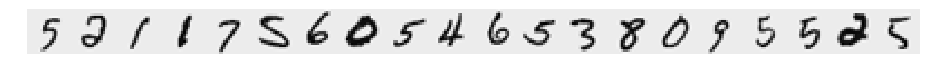

In [4]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1, 20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

In [5]:
weights = loadmat('data/ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [7]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
print("Given theta1", ndarray_description(theta1))
print("Given theta2", ndarray_description(theta2))

params = np.r_[theta1.ravel(), theta2.ravel()]  # quick way to create an array
print("params", ndarray_description(params))    # flattened vector of all params

Given theta1 shape: (25, 401), min: -1.463369318005054, max: 1.0089920104197974
Given theta2 shape: (10, 26), min: -4.030847527504247, max: 3.2115848427114373
params shape: (10285,), min: -4.030847527504247, max: 3.2115848427114373


## Feed Forward and Cost functions

### Sigmoid gradient
#### $$ g'(z) = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$

In [8]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [9]:
def sigmoid_gradient(z):
    return (sigmoid(z) * (1-sigmoid(z)))

### Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

K - number of units (excluding the bias) in layer l

In [11]:
def forward_propagate(X, theta1, theta2):
    """Given a set of examples and weights, compute the forward prop arrays.
    
    This is a vectorized solution!
    
    :param numpy.ndarray X: 5000 examples (rows) with 401 input values as vectors
    :param numpy.ndarray theta1: 25 hidden units receive 401 values
    :param numpy.ndarray theta2: 10 output units receive 26 values
    
    :returns: a1 - 5000 examples with 401 activation values for input layer
    :returns: z2 - 25 hidden layer values for each of the 5000 examples 
    :returns: a2 - 5000 examples with 26 activation values for hidden layer
    :returns: z3 - 10 output layer values for each of the 5000 examples
    :returns: a3 - 5000 examples with 10 activation values (probabilities) for each output class
    """
    m = X.shape[0]  # 5000
    a1 = X          # 5000x401, 5000 examples with 401 units to map to next layer
    
    z2 = theta1.dot(a1.T)  # 25x401 * 401x5000 = 25x5000
    a2 = np.insert(sigmoid(z2.T), 0, values=np.ones(m), axis=1) # 5000x26, 5000 examples with 26 units
    
    z3 = theta2.dot(a2.T)  # 10x26 * 26x5000 = 10x5000
    a3 = sigmoid(z3.T)     # 5000x10, 5000 examples with 10 output units (h vector)
    
    return a1, z2, a2, z3, a3

In [12]:
def cost(params, input_layer_size, hidden_layer_size, num_labels, X, y, learning_rate):
    """Given a set of examples and params, compute the cost and a vector of gradient values for each param.
    
    This is a vectorized solution!
    
    :param numpy.ndarray params: Vector of theta values for both layers, (10285,)
    :param int input_layer_size: number of input units, excluding bias
    :param int hidden_layer_size: number of hidden units, excluding bias
    :param int num_labels: number of output units, coresponding to class label
    :param numpy.ndarray X: 5000 examples (rows) with 401 input values as vectors
    :param numpy.ndarray y: 5000 labels (rows) with a single class, 1-10
    :param int learning_rate: lambda value
    
    :returns: J - an int of the cost value for given examples and params
    :returns: grad - numpy.ndarray vector (10285,) of gradient values for each theta
    """
    # Reshape params into arrays for each layer
    theta1 = params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, (input_layer_size+1))
    theta2 = params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, (hidden_layer_size+1))
    
    m = X.shape[0]  # 5000
    y_matrix = pd.get_dummies(y.ravel()).values  # ndarray (5000, 10)
    
    # Forward propagate
    a1, z2, a2, z3, a3 = forward_propagate(X, theta1, theta2)
    
    # Cost calculation, sums 5000x10 arrays
    J = -1*(1/m) * np.sum((np.log(a3)*(y_matrix) + np.log(1-a3)*(1-y_matrix))) # scalar
    
    # add regulation term
    reg = (learning_rate/(2*m)) * ( np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])) )  # scalar
    J += reg
    
    # d - error of each node
    d3 = a3 - y_matrix  # 5000x10, 5000 examples with 10 node error values in layer 3
    d2 = theta2[:, 1:].T.dot(d3.T) * sigmoid_gradient(z2)  # 25x10*10x5000 .* 25x5000 = 25x5000
    d2 = d2.T           # 5000x25, 5000 examples with 25 node error values in layer 2
    
    # deltas - error value for each theta value
    delta1 = d2.T.dot(a1)    # 25x5000*5000x401 = 25x401
    delta2 = d3.T.dot(a2)    # 10x5000*5000x26  = 10x26
    
    # replace first coumn of theta values with 1, for bias
    # c_ creates arrays with columns
    theta1_ = np.c_[np.ones((theta1.shape[0], 1)), theta1[:, 1:]]  # 25x401
    theta2_ = np.c_[np.ones((theta2.shape[0], 1)), theta2[:, 1:]]  # 10x26
    
    # compute theta gradients
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    # unravel the theta matrices into a single array (a tuple)
    grad = np.concatenate((np.ravel(theta1_grad), np.ravel(theta2_grad)))
    
    return J, grad

In [13]:
J, grad = cost(params, 400, 25, 10, X, y, 0)

In [14]:
print("Cost with given theta weights:", J)

Cost with given theta weights: 0.28762916516131887


In [15]:
print("grad", ndarray_description(grad))

grad shape: (10285,), min: -0.0019544251591015957, max: 0.0025968523726689185


## Train the network

### Setup
Define the number of uits in each layer, and a learning rate. Randomly initialize the theta parameters.

In [16]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25
print("initial random params", ndarray_description(params))

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

initial random params shape: (10285,), min: -0.12498500918588684, max: 0.12492675750659171


In [17]:
# Take a look at the forward propagation calculations for initial theta values
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

In [18]:
J, grad = cost(params, input_size, hidden_size, num_labels, X, y, learning_rate)
print("Initial cost", J)
print("Initial gradient", ndarray_description(grad))

Initial cost 6.992887053335521
Initial gradient shape: (10285,), min: -0.04395394906033365, max: 0.4495802021628922


### Train
Minimize the the parameters with cost and gradient calculations.

In [19]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(input_size, hidden_size, num_labels, X, y, learning_rate),
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.42384351564362704
     jac: array([-2.64548253e-05,  1.55371242e-06,  1.97247942e-06, ...,
        3.71886449e-04,  1.86636537e-05,  3.79541604e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 18
  status: 3
 success: False
       x: array([ 0.60936248,  0.02438891,  0.03096237, ...,  0.69969268,
       -0.92557465, -3.44444942])

In [28]:
opt_params = fmin.x
print("fmin.x, the optimized parameter values -", ndarray_description(opt_params))

fmin.x, the optimized parameter values - shape: (10285,), min: -7.593365932354857, max: 8.337163829183488


In [29]:
opt_grads = fmin.jac
print("fmin.jac, the optimized gradient values -", ndarray_description(opt_grads))

fmin.jac, the optimized gradient values - shape: (10285,), min: -0.0012042600886567408, max: 0.0012647309147665053


In [30]:
opt_theta1 = fmin.x[0:(25*(400+1))].reshape(25, (400+1))
print("opt_theta1 -", ndarray_description(opt_theta1))

opt_theta1 - shape: (25, 401), min: -2.523702767263656, max: 2.1772247357910177


In [31]:
opt_theta2 = fmin.x[(25*(400+1)):].reshape(10, (25+1))
print("opt_theta2 -", ndarray_description(opt_theta2))

opt_theta2 - shape: (10, 26), min: -7.593365932354857, max: 8.337163829183488


### Find Accuracy
Compute the predictions with optimized theta values.

In [32]:
a1, z2, a2, z3, h = forward_propagate(X, opt_theta1, opt_theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
print("y_pred", ndarray_description(y_pred))

y_pred shape: (5000,), min: 1, max: 10


In [33]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) /  float(len(correct)))
print("Accuracy:", accuracy*100)

Accuracy: 99.36


## Gradient checking

In [34]:
def check_gradient(thetas, deltas, X, y, learning_rate):
    """Check that 10 random gradient values are properly adjusting.
    
    For an epsilon of 10e-4, you can assume about 4 significant digits of similarity. If the
    difference between the actual gradient value and its calculated approximation is greater 
    than epsilon you may not be converging properly.
    
    :param numpy.ndarray thetas: A vector (10285,) of optimized theta values
    :param numpy.ndarray deltas: A vector (10285,) of optimized delta values
    :param numpy.ndarray X: 5000 examples (rows) with 401 input values as vectors
    :param numpy.ndarray y: 5000 labels (rows) with a single class, 1-10
    :param int learning_rate: lambda value
    """
    eps = 0.0001  # 10e-4
    n_elements = len(thetas)
    
    # pick 10 random examples to test
    for i in range(10):
        x = int(np.random.rand()*n_elements)
        
        # Create a vector of 0s for the epsilon differential 
        eps_vector = np.zeros((n_elements, 1))
        eps_vector[x] = eps
        eps_vector = eps_vector.ravel()
        
        # Visually inspect that the approximation is similar to the gradient value
        cost_high, _ = cost(thetas + eps_vector, 400, 25, 10, X, y, learning_rate)
        cost_low, _ = cost(thetas - eps_vector, 400, 25, 10, X, y, learning_rate)
        approximate_grad = (cost_high - cost_low) / float(2*eps)
        print("Example {}: gradient {} ~= approximate {}".format(x, deltas[x], approximate_grad))
        print("            difference {}".format(deltas[x] - approximate_grad))
        

In [35]:
check_gradient(opt_params, opt_grads, X, y, learning_rate)

Example 9223: gradient 0.00045796519414372314 ~= approximate 0.00039425949005522654
            difference 6.37057040884966e-05
Example 1559: gradient -2.1374457865392663e-05 ~= approximate -4.196581998572313e-05
            difference 2.0591362120330466e-05
Example 8032: gradient 1.1820688211391171e-07 ~= approximate 3.589517572066825e-07
            difference -2.407448750927708e-07
Example 748: gradient -4.249225790059663e-06 ~= approximate 7.785341510357924e-05
            difference -8.210264089363891e-05
Example 206: gradient 4.44954599443425e-05 ~= approximate 1.8208119734186567e-05
            difference 2.6287340210155933e-05
Example 6219: gradient 0.00020805402733261826 ~= approximate 0.00025225323246891307
            difference -4.419920513629481e-05
Example 5877: gradient 2.473032595594491e-05 ~= approximate 3.0120398675226312e-05
            difference -5.390072719281403e-06
Example 6713: gradient -8.448098895357415e-05 ~= approximate -7.583809802369501e-05
            di

## Visualize the hidden layer
The trained theta1 values represent weights of each input pixel. 

In [96]:
import scipy.misc
import matplotlib.cm as cm

def display_hidden_layer(thetas):
    """Quick way to visualize hidden layer, but uses depricated functions."""
    # remove bias unit
    params = thetas[:, 1:]
    assert params.shape == (25, 400)
    
    width, height = 20, 20
    nrows, ncolumns = 5, 5
    big_picture = np.zeros((height*nrows, width*ncolumns))
    
    irow, icolumn = 0, 0
    for row in params:
        if icolumn == ncolumns:
            irow += 1
            icolumn = 0
            
        # create visualization
        square = row.reshape(20, 20).T
        big_picture[irow*height:irow*height+square.shape[0],
                    icolumn*width:icolumn*width+square.shape[1]] = square
        icolumn += 1
        
    fig = plt.figure(figsize=(6, 6))
    img = scipy.misc.toimage(big_picture)
    plt.imshow(img, cmap=cm.Greys_r)

/Users/joeselvik/.virtualenvs/machine-learning-coursera/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


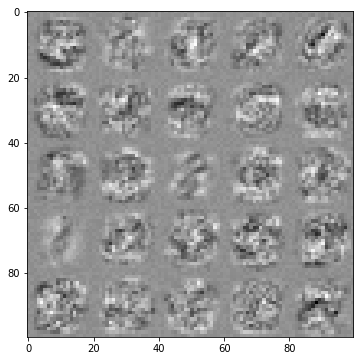

In [97]:
display_hidden_layer(opt_theta1)